### GW tutorial 1: Ground-based antenna pattern and redshift horizon

Author: Melissa Lopez

Email: m.lopez@uu.nl

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#### Network antenna patterns

Interferometric detectors are omnidirectional antennas and have a good sensitivity over a large fraction of the sky. The output of the detector will be $h(t)$, which will respond to a passing gravitational wave (GW) as $h_{ij}(t, \textbf{x})$. The general transfer function for GW detectors is

\begin{equation}
\label{eq:outputdetector}
h(t, \textbf{x}) = D^{ij}h_{ij}(t, \textbf{x}),
\end{equation}
where $D_{ij}$ is the detector tensor that depends on its geometry.
For a ground-based detector, we can neglect the spatial dependence of the GW signal $h_{ij}(t, \textbf{x})$, such that

\begin{equation}
h_{ij}(t) = \sum_{A=\text{+}, \times} e^{A}_{ij}(\hat{\textbf{n}}) h_{A}(t).
\end{equation}

The direction of propagation of the wave is $\hat{\textbf{k}}$,  and  $e^{A}_{ij}$ the polarization tensor defined as

\begin{equation}
 e^{A}_{ij}(\hat{\textbf{k}}) = 
   \begin{cases} 
      \hat{\textbf{u}}_{i}\hat{\textbf{u}}_{j} - \hat{\textbf{v}}_{i}\hat{\textbf{v}}_{j}              & \mbox{for } A=\text{+}   \\
      \hat{\textbf{u}}_{i}\hat{\textbf{v}}_{j} + \hat{\textbf{v}}_{i}\hat{\textbf{u}}_{j}  & \mbox{for } A=\times
   \end{cases}
\end{equation}
where $\hat{\textbf{u}} \text{ and } \hat{\textbf{v}}$ are unit vectors orthogonal to $\hat{\textbf{k}}$. This would be the case when the polarization angle $\psi$ is negligible, so to add this information we can rewrite the polarization tensor as,


\begin{equation}
 e^{rot, A}_{ij}(\hat{\textbf{k}}) = 
   \begin{cases} 
      \cos{(2\psi)} e^{+}_{ij}(\hat{\textbf{k}}) - \sin{(2\psi)} e^{\times}_{ij}(\hat{\textbf{k}})           & \mbox{for } A=\text{+}   \\
      \sin{(2\psi)} e^{+}_{ij}(\hat{\textbf{k}}) + \cos{(2\psi)} e^{\times}_{ij}(\hat{\textbf{k}})  & \mbox{for } A=\times
   \end{cases}
\end{equation}

**Exercise 1:** create a function called `polarization_tensors` that returns $e_{ij}^{rot, A}(\hat{\textbf{k}})$  in the celestial frame for both polarizations as a function of the wave propagation $\hat{\textbf{k}}$ and the polarization angle $\psi$. Also, create a function called `direction_propagation` that computes $\hat{\textbf{k}}(\theta, \phi) = [\sin{\theta} \cos{\phi}, \sin{\theta} \sin{\phi}, \cos{\theta}]$

_Hint_: Given a unit sphere the unit vector orthogonal to $\hat{\textbf{k}}$ are $e_{\theta} = [\cos{\theta}\cos{\phi}, \cos{\theta}\sin{\phi}, -\sin{\theta}]$ and $e_{\phi} = [- \sin{\phi}, \cos{\phi}, 0]$

In [2]:
# Solution
def polarization_tensors(theta, phi, psi):
    """
    Compute the plus and cross polarization tensors in the celestial frame.
    theta, phi: direction of wave propagation in celestial coordinates
    psi: polarization angle
    """
    
    # Basis vectors in spherical coordinates
    e_theta = np.array([np.cos(theta) * np.cos(phi),
                        np.cos(theta) * np.sin(phi),
                        -np.sin(theta)])
    e_phi = np.array([-np.sin(phi), np.cos(phi), 0])

    # Plus polarization tensor
    e_plus = np.outer(e_theta, e_theta) - np.outer(e_phi, e_phi)

    # Cross polarization tensor
    e_cross = np.outer(e_theta, e_phi) + np.outer(e_phi, e_theta)

    # Rotate by polarization angle psi
    e_plus_rot = np.cos(2 * psi) * e_plus - np.sin(2 * psi) * e_cross
    e_cross_rot = np.sin(2 * psi) * e_plus + np.cos(2 * psi) * e_cross

    return e_plus_rot, e_cross_rot

def direction_propagation(theta, phi):
    k = np.array([np.sin(theta) * np.cos(phi),
                  np.sin(theta) * np.sin(phi),
                  np.cos(theta)])
    return k

Now, we have the polarization tensors taking into account the polarization angle $\psi$. However, this is in celestial coordinates and we need to rotate our vectors according to the local detector frame. 

**Exercise 2:** Assuming that a given detector is located at $(\theta_{0}, \phi_{0})$ write a function called rotation matrix.

_Hint_: we need to rotate the z-axis to account for $\theta_0$ and to rotate the x-axis for $\phi_{0}$, so that $R = R_{x}(\pi/2 - \phi_{0}) \cdot R_{z}(\pi /2 +\theta_{0})$

In [3]:
# Solution

The function defines a rotation matrix \( R \) that transforms celestial coordinates (global) to the local detector frame (local). This involves two rotations: one for the detector's longitude (\(\theta_0\)) and one for its latitude (\(\phi_0\)).

Note that $\cos{(\pi/2 - \psi)} = \sin{\psi}$, $\sin{(\pi/2 - \psi)} = \cos{\psi}$, while $\cos{(\pi/2 + \psi)} = - \sin{\psi}$, $\sin{(\pi/2 + \psi)} = \cos{\psi}$
The rotation matrix for a rotation around the \( z \)-axis is:
$
R_z(\pi/2 + \theta_0) = 
\begin{bmatrix}
-\sin\theta_0 & \cos\theta_0 & 0 \\
-\cos\theta_0 & -\sin\theta_0 & 0 \\
0 & 0 & 1
\end{bmatrix}
$

The rotation matrix for a rotation around the \( x \)-axis is:
$
R_x(\pi/2 - \phi_0) = 
\begin{bmatrix}
1 & 0 & 0 \\
0 & \sin\phi_0 & \cos\phi_0 \\
0 & -\cos\phi_0 & \sin\phi_0
\end{bmatrix}
$

The combined rotation matrix \( R \) is the product of these two matrices:
$R =  R_x(\pi/2 - \phi_0) \cdot R_z(\pi/2 +\theta_0)$

$
R = 
\begin{bmatrix}
-\sin\theta_0 & \cos\theta_0 & 0 \\
-\sin\phi_0 \cos\theta_0 & -\sin\phi_0 \sin\theta_0 & \cos\phi_0 \\
\cos\phi_0 \cos\theta_0 & \cos\phi_0 \sin\theta_0 & \sin\phi_0.
\end{bmatrix}
$

Thus, the function is implemented as

In [4]:
def rotation_matrix(theta_0, phi_0):
    """
    Create a rotation matrix to transform celestial coordinates to the local detector frame.
    theta_0: longitude of the detector (radians)
    phi_0: latitude of the detector (radians)
    """
    sin_theta = np.sin(theta_0)
    cos_theta = np.cos(theta_0)
    sin_phi = np.sin(phi_0)
    cos_phi = np.cos(phi_0)

    # Define the rotation matrix
    R = np.array([
        [-sin_theta, cos_theta, 0],
        [-sin_phi * cos_theta, -sin_phi * sin_theta, cos_phi],
        [cos_phi * cos_theta, cos_phi * sin_theta, sin_phi]
    ])
    return R

So far we have computed the `R = rotation_matrix(theta_0, phi_0)`, the direction of propagation `k = direction_propagation(theta, phi)` and the polarization tensors $e_+$ and $e_{\times}$ with the `polarization_tensors` function. Now, we have all the ingredients to calculate the antenna pattern.


For an L shape detector such as current Advanced LIGO and Advanced Virgo the output of the detector the antenna pattern defined as $F = F_{+}^2 + F_{\times}^{2}$ where

$F_{+}(\theta, \phi, \psi) = \frac{1}{2}[(d_{x}^{T} e_{+}^{local} d_{x})- (d_{y}^{T} e_{+}^{local} d_{y})],$

$F_{\times}(\theta, \phi, \psi) = \frac{1}{2}[(d_{x}^{T} e_{\times}^{local} d_{x})- (d_{y}^{T} e_{\times}^{local} d_{y})].$

Here, $d_{x}$ and $d_{y}$ are the directions of the detector arms in the local frame are defined as:
$
\mathbf{d}_x = 
\begin{bmatrix}
\cos\alpha \\
\sin\alpha \\
0
\end{bmatrix},
\quad
\mathbf{d}_y = 
\begin{bmatrix}
-\sin\alpha \\
\cos\alpha \\
0
\end{bmatrix}.
$

**Excercise 3:** Create a function called `antenna_pattern(theta, phi, psi, theta_0, phi_0, alpha)`.


_Hint:_ The wave propagation vector $\mathbf{k}$ and polarization tensors $e_+$ and $e_\times$ are transformed to the detector's local frame as follows:

$
\mathbf{k}_\text{local} = R \cdot \mathbf{k}(\theta, \phi),
$

$
e_+^\text{local} = R \cdot e_+ \cdot R^\mathsf{T},
$

$
e_\times^\text{local} = R \cdot e_\times \cdot R^\mathsf{T},
$

where $R^{T}$ denotes the transpose of the rotation matrix \(R\).



In [5]:
# Solution

In [6]:
def antenna_pattern(theta, phi, psi, theta_0, phi_0, alpha):
    """
    Compute the antenna pattern functions F_+ and F_x for a detector located on Earth.
    theta, phi: wave propagation direction in celestial coordinates
    psi: polarization angle
    theta_0, phi_0: detector location (longitude and latitude)
    alpha: detector orientation (angle of the x-arm relative to North)
    """
    # Rotation matrix to transform celestial coordinates to detector frame
    R = rotation_matrix(theta_0, phi_0)

    # Transform wave propagation vector and polarization tensors to local frame
    k_local = R @ direction_propagation(theta, phi)

    e_plus, e_cross = polarization_tensors(theta, phi, psi)
    e_plus_local = R @ e_plus @ R.T
    e_cross_local = R @ e_cross @ R.T

    # Detector arm directions in local frame
    dx = np.array([np.cos(alpha), np.sin(alpha), 0])
    dy = np.array([-np.sin(alpha), np.cos(alpha), 0])

    # Compute antenna patterns
    F_plus = 0.5 * ((dx @ e_plus_local @ dx) - (dy @ e_plus_local @ dy))
    F_cross = 0.5 * ((dx @ e_cross_local @ dx) - (dy @ e_cross_local @ dy))

    return np.sqrt(F_plus**2 + F_cross**2)

Alright, now let's see what this antenna pattern looks like. Below I coded a function to plot it (you are welcome). If everything looks fine it should look like the plot on the slides.

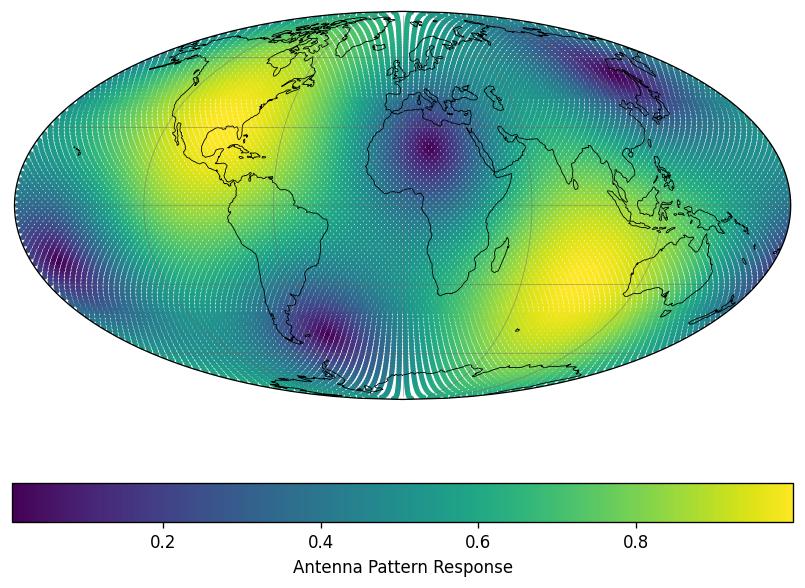

In [7]:
def plot_antenna_pattern(theta_0, phi_0, alpha, psi, nside=32):
    """
    Plot the antenna pattern using Cartopy with Mollweide projection.
    theta_0, phi_0: Detector location (longitude and latitude in radians)
    alpha: Detector orientation (angle of x-arm relative to North in radians)
    psi: Polarization angle
    nside: Resolution parameter for the Healpix map
    """
    npix = hp.nside2npix(nside)
    antenna_map = np.zeros(npix)

    # Compute the antenna pattern
    for pix in range(npix):
        theta, phi = hp.pix2ang(nside, pix)
        antenna_map[pix] = antenna_pattern(theta, phi, psi, theta_0, phi_0, alpha)

    # Healpy's pixel centers for plotting (convert to degrees)
    lon, lat = hp.pix2ang(nside, np.arange(npix), lonlat=True)  # Lon/lat in degrees
    lat = np.radians(lat)  # Convert latitude to radians for Cartopy
    lon = np.radians(lon)  # Convert longitude to radians for Cartopy

    # Create a Mollweide plot using Cartopy
    fig = plt.figure(figsize=(12, 6), dpi=120)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())

    # Plot the antenna pattern on Cartopy map
    pc = ax.scatter(lon * 180 / np.pi, lat * 180 / np.pi, c=antenna_map, cmap="viridis", s=5, transform=ccrs.PlateCarree())
    
    # Add coastlines and gridlines
    ax.coastlines(color='black', linewidth=0.5)
    ax.set_global()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=0.5, color='dimgrey', alpha=0.5)

    # Add colorbar
    cbar = fig.colorbar(pc, orientation="horizontal", shrink=0.7)
    cbar.set_label("Antenna Pattern Response")
    plt.show()


# Detector location: LIGO Livingston
lat = 30  # Latitude in degrees
lon = -90  # Longitude in degrees
yangle = 160.0  # Y-arm orientation in degrees (clockwise from North)

# Convert to radians for computation
theta_0 = np.radians(lon)
phi_0 = np.radians(lat)
alpha = np.radians(yangle - 90)  # Convert Y-arm to x-arm orientation
psi = 0  # Polarization angle

plot_antenna_pattern(theta_0, phi_0, alpha, psi)


Good job! You are almost at the end of the first part. Now, what can you tell me about the "blind" spots of the detector? Where are they located? Where is the best place to see a gravitational wave?

**Excersice 4:** What about other detectors? Can you remake this plot? See details below:

- _LIGO Hanford:_ lat = 46.45, lon = -119.41, yangle = 171.8

- _Virgo:_ lat = 43.63, lon = 10.5, yangle = 250.0

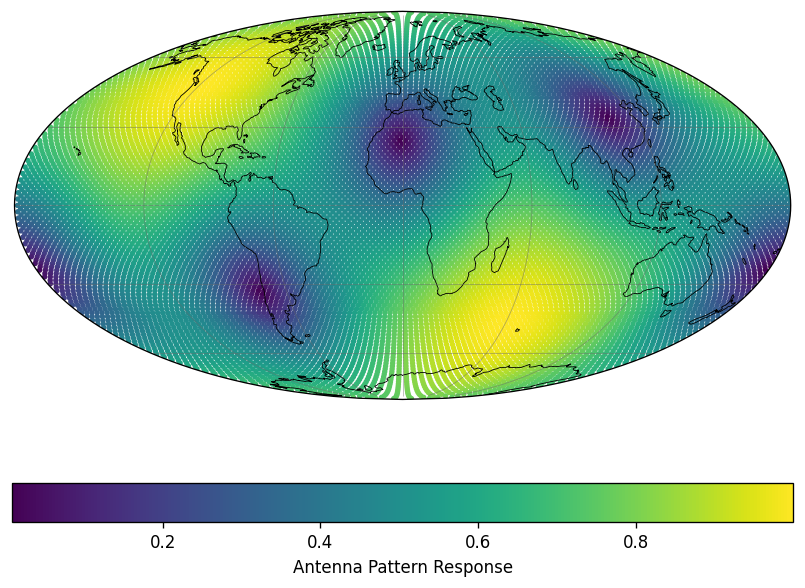

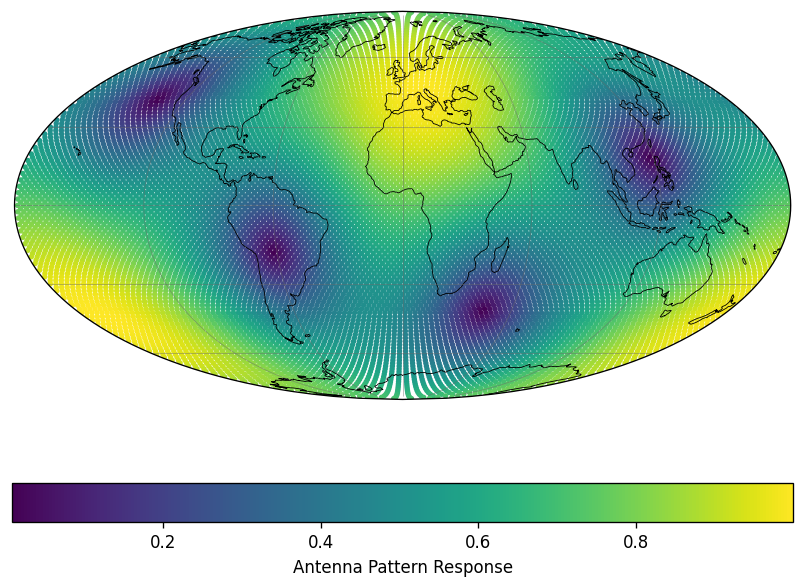

In [8]:
# Solution

# Detector location: LIGO Hanford
lat = 46.45   # Latitude in degrees
lon = -119.41   # Longitude in degrees
yangle = 171.8  # Y-arm orientation in degrees (clockwise from North)

# Convert to radians for computation
theta_0 = np.radians(lon)
phi_0 = np.radians(lat)
alpha = np.radians(yangle - 90)  # Convert Y-arm to x-arm orientation
psi = 0  # Polarization angle

plot_antenna_pattern(theta_0, phi_0, alpha, psi)

# Detector location: LIGO Hanford
lat = 43.63   # Latitude in degrees
lon = 10.5   # Longitude in degrees
yangle = 250.0  # Y-arm orientation in degrees (clockwise from North)

# Convert to radians for computation
theta_0 = np.radians(lon)
phi_0 = np.radians(lat)
alpha = np.radians(yangle - 90)  # Convert Y-arm to x-arm orientation
psi = 0  # Polarization angle

plot_antenna_pattern(theta_0, phi_0, alpha, psi)

Do you want a curiosity about the detection of the first binary neutron star? [Here](https://dcc.ligo.org/public/0146/G1701985/001/bayestar_no_virgo.png) is the sky map. Where is it located? What can Virgo see? Is it a good thing or a bad thing?